In [382]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from datetime import datetime

In [383]:
#Read the csv file
prices_df = pd.read_csv('prices/BTC-USD.csv')
trends_df = pd.read_csv('trends/bitcoin.csv')

def create_df(trends_df, prices_df):
    # Clean trends_df
    trends_df.reset_index(drop=False, inplace=True)
    trends_df.columns = trends_df.iloc[0]
    trends_df = trends_df[1:][:]
    trends_df.columns = ['Week', 'Trends']

    # Create 'Trends' column in prices_df
    prices_df['Trends'] = 0
    # Convert 'Date' into datetime
    prices_df['Date'] = pd.to_datetime(prices_df['Date'])
    trends_df['Week'] = pd.to_datetime(trends_df['Week'])

    # Look for the latest start date
    start_date = trends_df['Week'].iloc[0]
    if(prices_df['Date'].iloc[0] > trends_df['Week'].iloc[0]):
        start_date = prices_df['Week'].iloc[0]
    prices_df = prices_df[prices_df['Date']>=start_date]

    # Interpolate Trends
    days = len(prices_df)
    weeks = days//7
    modulo = days % 7 

    prices_df.reset_index(inplace=True, drop=True)
    trends_df.reset_index(inplace=True, drop=True)

    for i in range(0, weeks):
        for j in range(0,7):
            prices_df.loc[i*7+j, 'Trends'] = int(trends_df.loc[i, 'Trends'])
    for k in range(weeks*7, days):
        prices_df.loc[k, 'Trends'] = int(trends_df.loc[trends_df.index[-1], 'Trends'])
    
    df = prices_df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Trends']]
    train_dates = pd.to_datetime(prices_df['Date'])
    return df, train_dates

df, train_dates = create_df(trends_df, prices_df)

In [397]:
#Variables for training
cols = ['Trends', 'High', 'Low', 'Close', 'Open']
#Date and volume columns are not used in training. 
print(cols) #['Open', 'High', 'Low', 'Close', 'Adj Close']

['Trends', 'High', 'Low', 'Close', 'Open']


In [398]:
#New dataframe with only training data - 5 columns
df_for_training = df[cols].astype(float)

In [399]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [400]:
#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (1816, 14, 5).
trainY shape == (1816, 1).


In [401]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

c:\Users\victo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_78 (LSTM)                  │ (None, 14, 64)         │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_79 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,009 (199.25 KB)

 Trainable params: 51,009 (199.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - loss: 0.5154 - val_loss: 0.4129
Epoch 2/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.2344 - val_loss: 0.1190
Epoch 3/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1684 - val_loss: 0.0964
Epoch 4/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.1969 - val_loss: 0.0649
Epoch 5/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1240 - val_loss: 0.0654
Epoch 6/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1159 - val_loss: 0.0665
Epoch 7/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1251 - val_loss: 0.0525
Epoch 8/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1226 - val_loss: 0.0537
Epoch 9/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.1103 - val_loss: 0.0514
Epoch 10/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.1215 - val_loss: 0.0433
Epoch 11/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0725 - val_loss: 0.0566
Epoch 12/20
103/103 ━━━━━━━━━━━━━━━━━━━━

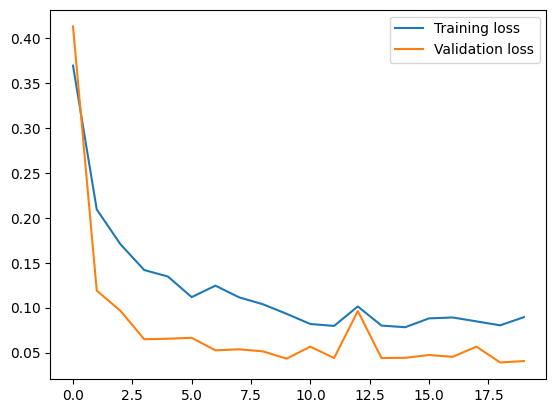

In [402]:
# fit the model
history = model.fit(trainX, trainY, epochs=20, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [430]:
#Predicting...
#Libraries that will help us extract only business days in the US.
#Otherwise our dates would be wrong when we look back (or forward).  
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
#Remember that we can only predict one day in future as our model needs 5 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_past = 16
n_days_for_prediction=15  #let us predict past 15 days

predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
print(predict_period_dates)

[Timestamp('2024-03-25 00:00:00'), Timestamp('2024-03-26 00:00:00'), Timestamp('2024-03-27 00:00:00'), Timestamp('2024-03-28 00:00:00'), Timestamp('2024-03-29 00:00:00'), Timestamp('2024-04-01 00:00:00'), Timestamp('2024-04-02 00:00:00'), Timestamp('2024-04-03 00:00:00'), Timestamp('2024-04-04 00:00:00'), Timestamp('2024-04-05 00:00:00'), Timestamp('2024-04-08 00:00:00'), Timestamp('2024-04-09 00:00:00'), Timestamp('2024-04-10 00:00:00'), Timestamp('2024-04-11 00:00:00'), Timestamp('2024-04-12 00:00:00')]


In [432]:
#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


In [426]:
# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Trends':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

C:\Users\victo\AppData\Local\Temp\ipykernel_16184\2676761551.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])


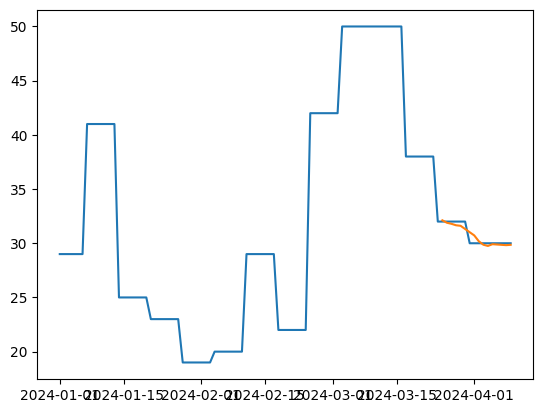

In [434]:
original = df[['Date', 'Trends']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2024-1-1']

plt.plot(original['Date'], original['Trends'])
plt.plot(df_forecast['Date'], df_forecast['Trends'])

In [428]:
filtered_original = original[original['Date'].isin(df_forecast['Date'])]
df_forecast = df_forecast.iloc[:12]


In [429]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Assuming y_true contains the actual values and y_pred contains the predicted values
y_true = filtered_original['Trends']
y_pred = df_forecast['Trends']

# Mean Squared Error (MSE)
mse = mean_squared_error(y_true, y_pred)
print("Mean Squared Error (MSE):", mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print("Mean Absolute Percentage Error (MAPE):", mape)

# Coefficient of Determination (R-squared)
r_squared = r2_score(y_true, y_pred)
print("Coefficient of Determination (R-squared):", r_squared)


Mean Squared Error (MSE): 0.08607807934580099
Mean Absolute Error (MAE): 0.23857339223225912
Root Mean Squared Error (RMSE): 0.29339065994983715
Mean Absolute Percentage Error (MAPE): nan
Coefficient of Determination (R-squared): 0.9114625469586047
